<a href="https://colab.research.google.com/github/Adeyinka-hub/MY-MACHINE-LEARNING-AND-DEEP-LEARNING-WORKS-ON-KAGGLE-AND-ZINDI-RESPECTIVELY/blob/master/CGIAR_Crop_Yield_Prediction_Challenge(Deep_Neural_Network_with_Tensorflow)%3D%3E1.70481%20on%20LB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

This notebook is a 'quick-start' for the [CGIAR Crop Yield Prediction Challenge](https://zindi.africa/competitions/cgiar-crop-yield-prediction-challenge). We'll take a look at the data, fit a quick model and make a submission, with hints at each stage for extra options to investigate.

Let's dive in!

In [ ]:
import numpy as np
import pandas as pd
import random
seed = 2891  
random.seed(seed)
np.random.seed(seed)

In [ ]:
from google.colab import drive
drive.mount("/content/drive/")

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
# Copying in the zip files from Google Drive (alternately just upload them)
!cp 'drive/My Drive/image_arrays_train.zip' .
!cp 'drive/My Drive/image_arrays_test.zip' .

In [ ]:
# Extract
!unzip -q image_arrays_train.zip
!unzip -q image_arrays_test.zip

replace image_arrays_train/1QMHQTJ.npy? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace image_arrays_train/KSQTPAS.npy? [y]es, [n]o, [A]ll, [N]one, [r]ename: replace image_arrays_test/BJAS0RL.npy? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
# Check the CSV files are present
!ls *.csv # Upload through the files menu

Leaky_relu.csv		    submission_continuous.csv  train_df.csv
SampleSubmission_yield.csv  test_df.csv		       Train_yield.csv


In [ ]:
# Check for bandnames.txt
!ls *.txt

band_names.txt


# Loading the data

The data isn't a simple table - instead we must read the inputs from individual .npy files. Here we'll load the dataframes, open a file or two and take a look at the format.

In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

In [ ]:
# Train.csv has the Field_IDs needed to find the npy files
train_new = pd.read_csv('Train_yield.csv')
print(train_new.shape)
train_new.head()

(2977, 4)


,Field_ID,Year,Quality,Yield
0,MH2O0YH,2019,3,3.686
1,O9TURWL,2019,2,5.657
2,35AFSDD,2019,3,3.082
3,PM05EG9,2019,2,2.707
4,V7PZBCG,2019,2,2.679


In [ ]:
train_new['Quality'].value_counts()

3    1321
2    1231
1     425
Name: Quality, dtype: int64

In [ ]:
train_new['Year'].value_counts()

2017    1203
2016    1024
2019     569
2018     181
Name: Year, dtype: int64

In [ ]:
ss = pd.read_csv('SampleSubmission_yield.csv')

Loading image_arrays_train/8AZ490K.npy as an array
Array shape: (360, 41, 40)


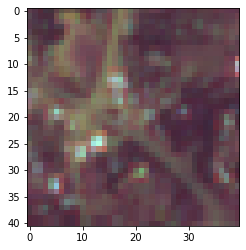

In [ ]:
# Look at a sample:
fid = train_new['Field_ID'].sample().values[0]
fn = f'image_arrays_train/{fid}.npy' # File name based on Field_ID
print(f'Loading {fn} as an array')
arr = np.load(fn) # Loading the data with numpy
print('Array shape:', arr.shape) # 360 bands, images 40 or 41px a side
rgb_jan = np.stack([arr[4], arr[3], arr[2]], axis=-1) # Combine three bands for viewing
rgb_jan = rgb_jan / np.max(rgb_jan) # Scale band values to (0, 1) for easy image display
plt.imshow(rgb_jan) # View with matplotlib

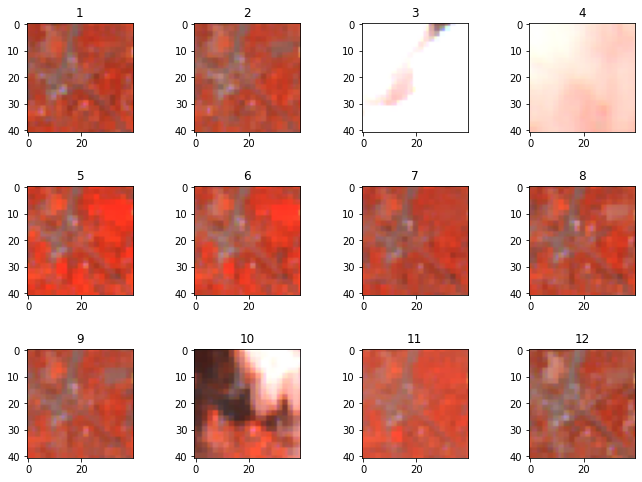

In [ ]:
# View false colour images from each month in the year:
fig, axs = plt.subplots(3, 4, figsize=(12, 8), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.001)
axs = axs.ravel()
for i in range(12):
  rgb = np.stack([arr[i*30 + 8], arr[i*30 + 4], arr[i*30 + 3]], axis=-1) # False colour (band 8, 4 and 3)
  rgb = rgb / 4000 # Scaling consistently 
  axs[i].imshow(rgb.clip(0, 1))
  axs[i].set_title(str(i+1))

What's with the white fluffy stuff? These are clouds - the bane of all remote sensing analysts...

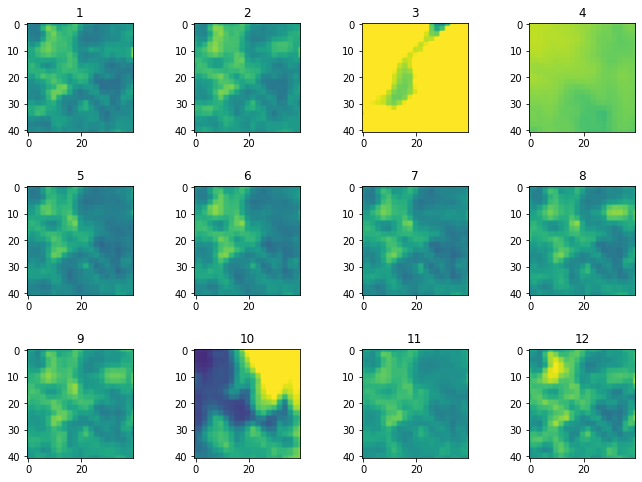

In [ ]:
# Show the SWIR band (B12) where clouds have a high reflectance
fig, axs = plt.subplots(3, 4, figsize=(12, 8), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.001)
axs = axs.ravel()
for i in range(12):
  cloud = arr[i*30 + 11]
  axs[i].imshow(cloud, vmin=0, vmax=4000)
  axs[i].set_title(str(i+1))

# Sampling from the images

There are some hard-coded band indexes in the examples above that won't have made sense - how did we know which bands were which?
There are 30 bands for each month. You can see the full list of bands with:

In [ ]:
band_names = [l.strip() for l in open('band_names.txt', 'r').readlines()]
print(band_names)

['0_S2_B1', '0_S2_B2', '0_S2_B3', '0_S2_B4', '0_S2_B5', '0_S2_B6', '0_S2_B7', '0_S2_B8', '0_S2_B8A', '0_S2_B9', '0_S2_B10', '0_S2_B11', '0_S2_B12', '0_S2_QA10', '0_S2_QA20', '0_S2_QA60', '0_CLIM_aet', '0_CLIM_def', '0_CLIM_pdsi', '0_CLIM_pet', '0_CLIM_pr', '0_CLIM_ro', '0_CLIM_soil', '0_CLIM_srad', '0_CLIM_swe', '0_CLIM_tmmn', '0_CLIM_tmmx', '0_CLIM_vap', '0_CLIM_vpd', '0_CLIM_vs', '1_S2_B1', '1_S2_B2', '1_S2_B3', '1_S2_B4', '1_S2_B5', '1_S2_B6', '1_S2_B7', '1_S2_B8', '1_S2_B8A', '1_S2_B9', '1_S2_B10', '1_S2_B11', '1_S2_B12', '1_S2_QA10', '1_S2_QA20', '1_S2_QA60', '1_CLIM_aet', '1_CLIM_def', '1_CLIM_pdsi', '1_CLIM_pet', '1_CLIM_pr', '1_CLIM_ro', '1_CLIM_soil', '1_CLIM_srad', '1_CLIM_swe', '1_CLIM_tmmn', '1_CLIM_tmmx', '1_CLIM_vap', '1_CLIM_vpd', '1_CLIM_vs', '2_S2_B1', '2_S2_B2', '2_S2_B3', '2_S2_B4', '2_S2_B5', '2_S2_B6', '2_S2_B7', '2_S2_B8', '2_S2_B8A', '2_S2_B9', '2_S2_B10', '2_S2_B11', '2_S2_B12', '2_S2_QA10', '2_S2_QA20', '2_S2_QA60', '2_CLIM_aet', '2_CLIM_def', '2_CLIM_pdsi', '2

0_S2_B1 is band one from the Sentinel 2 image for January (month 0). They're ordered, so we know that the first image band in the array is 0_S2_B1...

You'll likely want to examine specific bands. Here's an example where we create a function to sample the center point (20, 20) for specified bands from each month:

In [ ]:
def process_im(fid, folder='image_arrays_train'):
  fn = f'{folder}/{fid}.npy'
  arr = np.load(fn)
  bands_of_interest = ['S2_B5', 'S2_B4', 'S2_B3', 'S2_B2', 'CLIM_pr', 'CLIM_soil']
  
  values = {}
  for month in range(12):
    bns = [str(month) + '_' + b for b in bands_of_interest] # Bands of interest for this month 
    idxs = np.where(np.isin(band_names, bns)) # Index of these bands
    vs = arr[idxs, 20, 20] # Sample the im at the center point
    for bn, v in zip(bns, vs[0]):
      values[bn] = v
  return values

# Example
# process_im('35AFSDD')

With this, we can sample the inputs for each field in train and use that to build a dataframe of input features:

In [ ]:
# Make a new DF with the sampled values from each field 
train_sampled = pd.DataFrame([process_im(fid) for fid in train_new['Field_ID'].values])

# Add in the field ID and yield
train_sampled['Field_ID'] = train_new['Field_ID'].values
train_sampled['Yield'] = train_new['Yield'].values
train_sampled.head()

,0_S2_B5,0_S2_B4,0_S2_B3,0_S2_B2,0_CLIM_pr,0_CLIM_soil,1_S2_B5,1_S2_B4,1_S2_B3,1_S2_B2,1_CLIM_pr,1_CLIM_soil,2_S2_B5,2_S2_B4,2_S2_B3,2_S2_B2,2_CLIM_pr,2_CLIM_soil,3_S2_B5,3_S2_B4,3_S2_B3,3_S2_B2,3_CLIM_pr,3_CLIM_soil,4_S2_B5,4_S2_B4,4_S2_B3,4_S2_B2,4_CLIM_pr,4_CLIM_soil,5_S2_B5,5_S2_B4,5_S2_B3,5_S2_B2,5_CLIM_pr,5_CLIM_soil,6_S2_B5,6_S2_B4,6_S2_B3,6_S2_B2,6_CLIM_pr,6_CLIM_soil,7_S2_B5,7_S2_B4,7_S2_B3,7_S2_B2,7_CLIM_pr,7_CLIM_soil,8_S2_B5,8_S2_B4,8_S2_B3,8_S2_B2,8_CLIM_pr,8_CLIM_soil,9_S2_B5,9_S2_B4,9_S2_B3,9_S2_B2,9_CLIM_pr,9_CLIM_soil,10_S2_B5,10_S2_B4,10_S2_B3,10_S2_B2,10_CLIM_pr,10_CLIM_soil,11_S2_B5,11_S2_B4,11_S2_B3,11_S2_B2,11_CLIM_pr,11_CLIM_soil,Field_ID,Yield
0,934,932,1173,1392,4,287,1015,1036,1397,1516,7,236,1034,1075,1518,1640,14,200,1048,1085,1455,1561,47,175,1024,1084,1449,1605,76,155,6305,6128,6432,6511,88,139,749,611,360,518,72,126,1743,1487,1272,1743,92,116,903,928,1155,1322,81,107,893,998,903,1307,96,99,841,894,690,1162,83,93,744,699,393,790,125,215,MH2O0YH,3.686
1,880,821,924,1116,4,287,933,873,1011,1152,7,237,905,881,1020,1167,15,203,1893,1888,2178,2344,50,178,906,882,916,1037,80,158,943,803,506,677,86,142,922,922,679,1031,67,130,850,848,679,939,92,119,891,873,943,1135,74,110,841,844,817,1098,79,102,806,862,512,1037,78,96,703,524,323,420,126,215,O9TURWL,5.657
2,1016,1070,1357,1632,4,278,1108,1193,1588,1947,7,230,978,1018,1346,1472,15,197,1086,1117,1426,1584,50,173,1045,1095,1460,1663,77,154,8621,8414,8875,8692,83,139,843,822,491,841,65,126,838,798,552,859,89,116,845,908,764,1215,69,107,833,896,796,1186,73,100,967,1091,929,1538,75,93,2935,2961,3598,4145,135,289,35AFSDD,3.082
3,777,784,639,1064,3,299,832,875,823,1237,8,244,878,903,916,1231,14,207,932,907,973,1254,48,180,858,858,844,1108,79,159,914,846,570,902,90,143,1475,1348,1135,1311,75,130,3057,2836,2781,2997,94,119,764,779,501,982,85,109,798,823,581,1039,106,102,776,784,537,947,86,95,7289,7389,8025,8057,121,189,PM05EG9,2.707
4,1081,1122,1162,1487,20,427,1046,1063,1133,1454,18,300,1222,1339,1542,1834,35,234,985,1072,1046,1462,179,384,826,826,507,851,159,568,874,819,534,805,66,370,912,912,644,1029,29,273,980,995,882,1130,75,218,889,959,698,1178,85,182,923,984,694,1223,237,1179,973,958,657,1050,122,1123,1054,1097,789,1349,194,1214,V7PZBCG,2.679


In [ ]:
train_sampled.to_csv("train_df.csv", index = False) # Saving train dataset

In [ ]:
train_sampled = pd.read_csv("train_df.csv") # Reading back train dataset

In [ ]:
# Prep the data, using the same method we did for train
test_sampled = pd.DataFrame([process_im(fid, folder='image_arrays_test') for fid in ss['Field_ID'].values])
test_sampled.head()

,0_S2_B5,0_S2_B4,0_S2_B3,0_S2_B2,0_CLIM_pr,0_CLIM_soil,1_S2_B5,1_S2_B4,1_S2_B3,1_S2_B2,1_CLIM_pr,1_CLIM_soil,2_S2_B5,2_S2_B4,2_S2_B3,2_S2_B2,2_CLIM_pr,2_CLIM_soil,3_S2_B5,3_S2_B4,3_S2_B3,3_S2_B2,3_CLIM_pr,3_CLIM_soil,4_S2_B5,4_S2_B4,4_S2_B3,4_S2_B2,4_CLIM_pr,4_CLIM_soil,5_S2_B5,5_S2_B4,5_S2_B3,5_S2_B2,5_CLIM_pr,5_CLIM_soil,6_S2_B5,6_S2_B4,6_S2_B3,6_S2_B2,6_CLIM_pr,6_CLIM_soil,7_S2_B5,7_S2_B4,7_S2_B3,7_S2_B2,7_CLIM_pr,7_CLIM_soil,8_S2_B5,8_S2_B4,8_S2_B3,8_S2_B2,8_CLIM_pr,8_CLIM_soil,9_S2_B5,9_S2_B4,9_S2_B3,9_S2_B2,9_CLIM_pr,9_CLIM_soil,10_S2_B5,10_S2_B4,10_S2_B3,10_S2_B2,10_CLIM_pr,10_CLIM_soil,11_S2_B5,11_S2_B4,11_S2_B3,11_S2_B2,11_CLIM_pr,11_CLIM_soil
0,920,987,781,1252,32,326,958,991,1198,1361,33,226,1052,1162,1433,1664,51,175,5355,5049,5053,5312,184,433,854,877,806,1068,152,539,1503,1450,1182,1583,63,294,882,907,630,1064,43,211,1023,1121,1249,1508,78,166,801,712,673,895,70,138,1029,1187,1499,1700,178,488,811,839,555,934,124,435,922,944,697,1121,157,618
1,899,928,696,1129,32,326,970,972,1001,1265,33,226,957,1025,954,1405,51,175,972,989,971,1372,184,433,857,879,551,932,152,539,1672,1642,1484,1724,63,294,918,938,804,1035,43,211,914,955,781,1138,78,166,982,1012,756,1308,70,138,874,948,710,1245,178,488,927,1000,643,1214,124,435,900,879,629,1034,157,618
2,966,1019,960,1299,32,316,874,778,861,1015,33,220,937,919,1137,1262,52,170,900,894,1046,1182,188,453,777,723,524,754,154,574,1704,1641,1404,1690,64,308,858,804,559,828,42,216,904,878,1003,1059,77,168,989,944,1121,1228,66,139,863,854,944,1068,180,506,880,849,573,922,124,448,890,872,593,962,153,583
3,923,1032,672,1191,32,316,1066,1107,930,1271,33,220,961,1030,921,1246,52,170,1010,1071,1087,1305,188,453,970,1083,709,1214,154,574,1535,1467,1192,1565,64,308,1028,1051,739,1260,42,216,1008,1068,905,1231,77,168,1778,1847,1819,2045,66,139,913,1078,759,1240,180,506,1219,1208,823,1265,124,448,998,1099,736,1165,153,583
4,987,1047,1343,1441,32,316,949,991,1262,1273,33,220,1090,1246,1705,1829,52,170,1103,1286,1799,1698,188,453,848,874,688,1004,154,574,966,973,730,1152,64,308,873,822,541,900,42,216,1071,1170,1363,1421,77,168,1019,1111,1426,1541,66,139,982,1097,1405,1369,180,506,943,1025,879,1162,124,448,893,921,574,986,153,583


In [ ]:
test_sampled.to_csv("test_df.csv", index = False) # Saving test dataset

In [ ]:
test_sampled1 = pd.read_csv("test_df.csv") # Reading back test dataset
test_sampled1.head()

,0_S2_B5,0_S2_B4,0_S2_B3,0_S2_B2,0_CLIM_pr,0_CLIM_soil,1_S2_B5,1_S2_B4,1_S2_B3,1_S2_B2,1_CLIM_pr,1_CLIM_soil,2_S2_B5,2_S2_B4,2_S2_B3,2_S2_B2,2_CLIM_pr,2_CLIM_soil,3_S2_B5,3_S2_B4,3_S2_B3,3_S2_B2,3_CLIM_pr,3_CLIM_soil,4_S2_B5,4_S2_B4,4_S2_B3,4_S2_B2,4_CLIM_pr,4_CLIM_soil,5_S2_B5,5_S2_B4,5_S2_B3,5_S2_B2,5_CLIM_pr,5_CLIM_soil,6_S2_B5,6_S2_B4,6_S2_B3,6_S2_B2,6_CLIM_pr,6_CLIM_soil,7_S2_B5,7_S2_B4,7_S2_B3,7_S2_B2,7_CLIM_pr,7_CLIM_soil,8_S2_B5,8_S2_B4,8_S2_B3,8_S2_B2,8_CLIM_pr,8_CLIM_soil,9_S2_B5,9_S2_B4,9_S2_B3,9_S2_B2,9_CLIM_pr,9_CLIM_soil,10_S2_B5,10_S2_B4,10_S2_B3,10_S2_B2,10_CLIM_pr,10_CLIM_soil,11_S2_B5,11_S2_B4,11_S2_B3,11_S2_B2,11_CLIM_pr,11_CLIM_soil
0,920,987,781,1252,32,326,958,991,1198,1361,33,226,1052,1162,1433,1664,51,175,5355,5049,5053,5312,184,433,854,877,806,1068,152,539,1503,1450,1182,1583,63,294,882,907,630,1064,43,211,1023,1121,1249,1508,78,166,801,712,673,895,70,138,1029,1187,1499,1700,178,488,811,839,555,934,124,435,922,944,697,1121,157,618
1,899,928,696,1129,32,326,970,972,1001,1265,33,226,957,1025,954,1405,51,175,972,989,971,1372,184,433,857,879,551,932,152,539,1672,1642,1484,1724,63,294,918,938,804,1035,43,211,914,955,781,1138,78,166,982,1012,756,1308,70,138,874,948,710,1245,178,488,927,1000,643,1214,124,435,900,879,629,1034,157,618
2,966,1019,960,1299,32,316,874,778,861,1015,33,220,937,919,1137,1262,52,170,900,894,1046,1182,188,453,777,723,524,754,154,574,1704,1641,1404,1690,64,308,858,804,559,828,42,216,904,878,1003,1059,77,168,989,944,1121,1228,66,139,863,854,944,1068,180,506,880,849,573,922,124,448,890,872,593,962,153,583
3,923,1032,672,1191,32,316,1066,1107,930,1271,33,220,961,1030,921,1246,52,170,1010,1071,1087,1305,188,453,970,1083,709,1214,154,574,1535,1467,1192,1565,64,308,1028,1051,739,1260,42,216,1008,1068,905,1231,77,168,1778,1847,1819,2045,66,139,913,1078,759,1240,180,506,1219,1208,823,1265,124,448,998,1099,736,1165,153,583
4,987,1047,1343,1441,32,316,949,991,1262,1273,33,220,1090,1246,1705,1829,52,170,1103,1286,1799,1698,188,453,848,874,688,1004,154,574,966,973,730,1152,64,308,873,822,541,900,42,216,1071,1170,1363,1421,77,168,1019,1111,1426,1541,66,139,982,1097,1405,1369,180,506,943,1025,879,1162,124,448,893,921,574,986,153,583


In [ ]:
train_sampled.shape, test_sampled1.shape, ss.shape

((2977, 74), (1055, 72), (1055, 2))

#Application of Deep Neural Network with Tensorflow on "Zindi -CGIAR Crop Yield Prediction Challenge"

The purpose of this notebook is to build a model (Deep Neural Network) with Tensorflow. We will see the differents steps to do that. This notebook is split in several parts:

I. Importation & Devices Available

II. Outliers

III. Preprocessing

IV. DNNRegressor for Contiunuous features

V. Predictions

VI. Example with Leaky Relu

VII. DNNRegressor for Continuous and Categorial

VIII. Predictions bis

IX. Shallow Neural Network

X. Conclusion

We will expose 3 models. The first one will use just the continuous features, the second one we will add the categorical features and finally we will use a Neural Network with just one layer.

Theey are no tuning and we will use DNNRegressor with Relu for all activations functions and the number of units by layer are: [100, 75, 50, 25, 12]. So we have 5 layers.

In the part VI I show how to use another activation function with the example of Leaky Relu. Finally I will try to use a Shallow Neural Network (just with one Hidden Layer) just for fun.

If you have an idea to improve the performance of the model: Share it ! Fork it ! And play with it !

In [ ]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pylab import rcParams
import matplotlib
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

train = pd.read_csv('train_df.csv')
print('Shape of the train data with all features:', train.shape)
train = train.select_dtypes(exclude=['object'])
print("")
print('Shape of the train data with numerical features:', train.shape)

test = pd.read_csv('test_df.csv')
test = test.select_dtypes(exclude=['object'])

print("")
print("List of features contained our dataset:",list(train.columns))

Shape of the train data with all features: (2977, 74)

Shape of the train data with numerical features: (2977, 73)

List of features contained our dataset: ['0_S2_B5', '0_S2_B4', '0_S2_B3', '0_S2_B2', '0_CLIM_pr', '0_CLIM_soil', '1_S2_B5', '1_S2_B4', '1_S2_B3', '1_S2_B2', '1_CLIM_pr', '1_CLIM_soil', '2_S2_B5', '2_S2_B4', '2_S2_B3', '2_S2_B2', '2_CLIM_pr', '2_CLIM_soil', '3_S2_B5', '3_S2_B4', '3_S2_B3', '3_S2_B2', '3_CLIM_pr', '3_CLIM_soil', '4_S2_B5', '4_S2_B4', '4_S2_B3', '4_S2_B2', '4_CLIM_pr', '4_CLIM_soil', '5_S2_B5', '5_S2_B4', '5_S2_B3', '5_S2_B2', '5_CLIM_pr', '5_CLIM_soil', '6_S2_B5', '6_S2_B4', '6_S2_B3', '6_S2_B2', '6_CLIM_pr', '6_CLIM_soil', '7_S2_B5', '7_S2_B4', '7_S2_B3', '7_S2_B2', '7_CLIM_pr', '7_CLIM_soil', '8_S2_B5', '8_S2_B4', '8_S2_B3', '8_S2_B2', '8_CLIM_pr', '8_CLIM_soil', '9_S2_B5', '9_S2_B4', '9_S2_B3', '9_S2_B2', '9_CLIM_pr', '9_CLIM_soil', '10_S2_B5', '10_S2_B4', '10_S2_B3', '10_S2_B2', '10_CLIM_pr', '10_CLIM_soil', '11_S2_B5', '11_S2_B4', '11_S2_B3', '11_S2_B2

In [ ]:
train.shape, test.shape

((2977, 73), (1055, 72))

#Outliers

In [ ]:
from sklearn.ensemble import IsolationForest

clf = IsolationForest(max_samples = 100, random_state = 42)
clf.fit(train)
y_noano = clf.predict(train)
y_noano = pd.DataFrame(y_noano, columns = ['Top'])
y_noano[y_noano['Top'] == 1].index.values

train = train.iloc[y_noano[y_noano['Top'] == 1].index.values]
train.reset_index(drop = True, inplace = True)
print("Number of Outliers:", y_noano[y_noano['Top'] == -1].shape[0])
print("Number of rows without outliers:", train.shape[0])

Number of Outliers: 211
Number of rows without outliers: 2766


In [ ]:
train.head(10)

,0_S2_B5,0_S2_B4,0_S2_B3,0_S2_B2,0_CLIM_pr,0_CLIM_soil,1_S2_B5,1_S2_B4,1_S2_B3,1_S2_B2,1_CLIM_pr,1_CLIM_soil,2_S2_B5,2_S2_B4,2_S2_B3,2_S2_B2,2_CLIM_pr,2_CLIM_soil,3_S2_B5,3_S2_B4,3_S2_B3,3_S2_B2,3_CLIM_pr,3_CLIM_soil,4_S2_B5,4_S2_B4,4_S2_B3,4_S2_B2,4_CLIM_pr,4_CLIM_soil,5_S2_B5,5_S2_B4,5_S2_B3,5_S2_B2,5_CLIM_pr,5_CLIM_soil,6_S2_B5,6_S2_B4,6_S2_B3,6_S2_B2,6_CLIM_pr,6_CLIM_soil,7_S2_B5,7_S2_B4,7_S2_B3,7_S2_B2,7_CLIM_pr,7_CLIM_soil,8_S2_B5,8_S2_B4,8_S2_B3,8_S2_B2,8_CLIM_pr,8_CLIM_soil,9_S2_B5,9_S2_B4,9_S2_B3,9_S2_B2,9_CLIM_pr,9_CLIM_soil,10_S2_B5,10_S2_B4,10_S2_B3,10_S2_B2,10_CLIM_pr,10_CLIM_soil,11_S2_B5,11_S2_B4,11_S2_B3,11_S2_B2,11_CLIM_pr,11_CLIM_soil,Yield
0,934,932,1173,1392,4,287,1015,1036,1397,1516,7,236,1034,1075,1518,1640,14,200,1048,1085,1455,1561,47,175,1024,1084,1449,1605,76,155,6305,6128,6432,6511,88,139,749,611,360,518,72,126,1743,1487,1272,1743,92,116,903,928,1155,1322,81,107,893,998,903,1307,96,99,841,894,690,1162,83,93,744,699,393,790,125,215,3.686
1,880,821,924,1116,4,287,933,873,1011,1152,7,237,905,881,1020,1167,15,203,1893,1888,2178,2344,50,178,906,882,916,1037,80,158,943,803,506,677,86,142,922,922,679,1031,67,130,850,848,679,939,92,119,891,873,943,1135,74,110,841,844,817,1098,79,102,806,862,512,1037,78,96,703,524,323,420,126,215,5.657
2,777,784,639,1064,3,299,832,875,823,1237,8,244,878,903,916,1231,14,207,932,907,973,1254,48,180,858,858,844,1108,79,159,914,846,570,902,90,143,1475,1348,1135,1311,75,130,3057,2836,2781,2997,94,119,764,779,501,982,85,109,798,823,581,1039,106,102,776,784,537,947,86,95,7289,7389,8025,8057,121,189,2.707
3,1081,1122,1162,1487,20,427,1046,1063,1133,1454,18,300,1222,1339,1542,1834,35,234,985,1072,1046,1462,179,384,826,826,507,851,159,568,874,819,534,805,66,370,912,912,644,1029,29,273,980,995,882,1130,75,218,889,959,698,1178,85,182,923,984,694,1223,237,1179,973,958,657,1050,122,1123,1054,1097,789,1349,194,1214,2.679
4,945,949,921,1365,18,425,1036,1116,1520,1676,16,303,1040,1136,1516,1695,37,238,992,1057,1311,1641,173,382,870,1003,596,1104,152,527,987,1071,693,1214,84,421,947,943,1035,1190,36,301,917,904,984,1213,88,237,876,1003,756,1443,108,196,850,1016,597,1423,226,1144,3482,3336,3216,3422,109,1048,1000,1017,789,1213,196,1252,4.317
5,963,945,958,1299,18,425,1010,1084,1446,1645,16,303,1070,1165,1608,1799,37,238,934,976,1068,1490,173,382,790,788,486,1015,152,527,924,948,586,1143,84,421,906,897,631,1169,36,301,955,974,1028,1250,88,237,901,1022,804,1399,108,196,894,1036,765,1413,226,1144,4141,4025,4137,4270,109,1048,818,635,393,540,196,1252,2.999
6,1043,1088,1100,1316,20,427,1122,1179,1511,1575,18,300,1189,1288,1611,1656,35,234,1069,1163,1258,1405,179,384,936,1028,613,1099,159,568,928,970,618,1051,66,370,929,916,630,1020,29,273,915,953,676,1084,75,218,906,958,725,1179,85,182,942,994,855,1225,237,1179,1368,1282,963,1503,122,1123,987,1070,715,1262,194,1214,4.199
7,1366,1268,1379,1552,19,431,1765,1545,1777,1608,16,304,1352,1409,1334,1619,37,238,1504,1619,1489,1603,176,377,1642,1630,1411,1383,159,575,1993,1558,1611,1409,75,421,1342,1474,1297,1301,33,300,1130,1196,1277,1435,82,236,1144,1297,1157,1370,98,195,1163,1512,1242,1485,230,1162,1247,1085,899,1226,112,1073,1377,1640,1456,1813,193,1242,3.505
8,1044,1054,1151,1331,17,423,1069,1126,1331,1580,14,302,1102,1225,1572,1729,36,238,968,980,1218,1404,157,261,787,835,493,871,151,406,1106,1032,718,1189,74,294,867,839,585,992,33,233,991,1029,942,1319,78,193,998,1060,932,1296,92,166,1002,1067,997,1350,205,902,1078,1074,977,1341,104,788,2763,2630,2594,2827,185,1257,5.039
9,1146,1190,1351,1571,20,421,1027,1055,1133,1484,18,296,1179,1257,1562,1719,34,231,1212,1334,1591,1888,173,314,705,525,317,359,160,503,883,870,596,961,64,330,910,902,600,1019,28,250,1009,1005,954,1251,70,203,950,1003,893,1325,78,171,967,1018,891,1269,231,1103,1061,1114,856,1300,126,1071,1141,1258,1132,1586,192,1193,2.520


#Preprocessing

In [ ]:
import warnings
warnings.filterwarnings('ignore')

col_train = list(train.columns)
col_train_bis = list(train.columns)

col_train_bis.remove('Yield')

mat_train = np.matrix(train)
mat_test  = np.matrix(test)
mat_new = np.matrix(train.drop('Yield',axis = 1))
mat_y = np.array(train.Yield).reshape((2766,1))

prepro_y = MinMaxScaler()
prepro_y.fit(mat_y)

prepro = MinMaxScaler()
prepro.fit(mat_train)

prepro_test = MinMaxScaler()
prepro_test.fit(mat_new)

train = pd.DataFrame(prepro.transform(mat_train),columns = col_train)
test  = pd.DataFrame(prepro_test.transform(mat_test),columns = col_train_bis)
train.head()

,0_S2_B5,0_S2_B4,0_S2_B3,0_S2_B2,0_CLIM_pr,0_CLIM_soil,1_S2_B5,1_S2_B4,1_S2_B3,1_S2_B2,1_CLIM_pr,1_CLIM_soil,2_S2_B5,2_S2_B4,2_S2_B3,2_S2_B2,2_CLIM_pr,2_CLIM_soil,3_S2_B5,3_S2_B4,3_S2_B3,3_S2_B2,3_CLIM_pr,3_CLIM_soil,4_S2_B5,4_S2_B4,4_S2_B3,4_S2_B2,4_CLIM_pr,4_CLIM_soil,5_S2_B5,5_S2_B4,5_S2_B3,5_S2_B2,5_CLIM_pr,5_CLIM_soil,6_S2_B5,6_S2_B4,6_S2_B3,6_S2_B2,6_CLIM_pr,6_CLIM_soil,7_S2_B5,7_S2_B4,7_S2_B3,7_S2_B2,7_CLIM_pr,7_CLIM_soil,8_S2_B5,8_S2_B4,8_S2_B3,8_S2_B2,8_CLIM_pr,8_CLIM_soil,9_S2_B5,9_S2_B4,9_S2_B3,9_S2_B2,9_CLIM_pr,9_CLIM_soil,10_S2_B5,10_S2_B4,10_S2_B3,10_S2_B2,10_CLIM_pr,10_CLIM_soil,11_S2_B5,11_S2_B4,11_S2_B3,11_S2_B2,11_CLIM_pr,11_CLIM_soil,Yield
0,0.284958,0.302775,0.408898,0.414009,0.026667,0.167057,0.043888,0.067266,0.113033,0.123304,0.024155,0.174504,0.0347,0.049016,0.097907,0.106257,0.062500,0.135108,0.053361,0.083172,0.138248,0.153199,0.000000,0.075130,0.062625,0.093529,0.149135,0.163919,0.098592,0.063211,0.730684,0.730920,0.731786,0.738357,0.181435,0.055485,0.005022,0.011894,0.004097,0.017826,0.479452,0.052953,0.220490,0.198832,0.171950,0.246212,0.262537,0.043997,0.026650,0.048588,0.086523,0.104296,0.380488,0.045455,0.030685,0.062174,0.068161,0.105421,0.122288,0.031868,0.025572,0.054463,0.045495,0.098785,0.182353,0.029638,0.014588,0.032287,0.014179,0.056242,0.394137,0.097093,0.255087
1,0.227754,0.209420,0.277013,0.256834,0.026667,0.167057,0.033146,0.046924,0.069962,0.083479,0.024155,0.175549,0.0218,0.029530,0.053742,0.063736,0.067708,0.138067,0.170478,0.194483,0.231925,0.257780,0.008772,0.077073,0.046869,0.067068,0.085134,0.096548,0.106640,0.065107,0.034411,0.035024,0.019356,0.032660,0.177215,0.057377,0.023122,0.044340,0.035971,0.073928,0.445205,0.055669,0.034913,0.070105,0.062661,0.101190,0.262537,0.045883,0.025420,0.042791,0.064712,0.084313,0.346341,0.047585,0.024378,0.043024,0.058276,0.081262,0.088757,0.033516,0.020307,0.049900,0.023062,0.082622,0.167647,0.031284,0.009200,0.009504,0.005908,0.013512,0.397394,0.097093,0.391488
2,0.118644,0.178301,0.126059,0.227221,0.020000,0.176425,0.019914,0.047173,0.048985,0.092779,0.028986,0.182863,0.0191,0.031740,0.044519,0.069489,0.062500,0.142012,0.037283,0.058497,0.075797,0.112194,0.002924,0.078368,0.040459,0.063925,0.076489,0.104970,0.104628,0.065740,0.030645,0.040643,0.027050,0.059877,0.185654,0.058008,0.080979,0.088785,0.081535,0.104549,0.500000,0.055669,0.493558,0.470588,0.450055,0.472403,0.268437,0.045883,0.012403,0.032884,0.019239,0.067963,0.400000,0.046875,0.019163,0.040413,0.031149,0.074442,0.142012,0.033516,0.015794,0.038780,0.026213,0.070985,0.191176,0.030735,0.874754,0.903268,0.915987,0.895484,0.381107,0.082830,0.187336
3,0.440678,0.462574,0.403072,0.468109,0.133333,0.276347,0.047950,0.070635,0.083575,0.116521,0.077295,0.241379,0.0535,0.075532,0.100035,0.123697,0.171875,0.168639,0.044629,0.081370,0.085255,0.139976,0.385965,0.210492,0.036186,0.059733,0.036023,0.074487,0.265594,0.324273,0.025451,0.037114,0.022722,0.048143,0.135021,0.201135,0.022076,0.043297,0.032474,0.073710,0.184932,0.152749,0.061929,0.099718,0.100074,0.135642,0.212389,0.108108,0.025215,0.051855,0.039506,0.088908,0.400000,0.098722,0.034324,0.060433,0.044138,0.095711,0.400394,0.625275,0.045427,0.063587,0.041336,0.084303,0.297059,0.594951,0.055329,0.084104,0.060971,0.120799,0.618893,0.645091,0.185398
4,0.296610,0.317073,0.275424,0.398633,0.120000,0.274785,0.046640,0.077249,0.126757,0.140810,0.067633,0.244514,0.0353,0.055143,0.097730,0.111201,0.182292,0.172584,0.045599,0.079290,0.119591,0.163884,0.368421,0.209197,0.042062,0.082919,0.046710,0.104495,0.251509,0.298357,0.040125,0.070047,0.041837,0.097617,0.172996,0.233291,0.025738,0.046531,0.071543,0.091317,0.232877,0.171758,0.048836,0.081386,0.118872,0.150613,0.250737,0.120050,0.023883,0.056492,0.045473,0.117226,0.512195,0.108665,0.025470,0.064412,0.032989,0.118830,0.378698,0.606044,0.422834,0.402623,0.363831,0.391001,0.258824,0.553787,0.048232,0.073688,0.060971,0.105093,0.625407,0.665935,0.298754



To use Tensorflow we need to transform our data (features) in a special format. As a reminder we have just the continuous features. So the first function used is: tf.contrib.layers.real_valued_column. More information here: https://www.tensorflow.org/api_docs/python/tf/contrib/layers/real_valued_column

The others cells allowed to us to create a train set and test set with our training data set.

In [ ]:
%tensorflow_version 1.x   # Downgrading tf to version 1.x

`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `1.x   # Downgrading tf to version 1.x`. This will be interpreted as: `1.x`.


TensorFlow 1.x selected.


In [ ]:
import tensorflow
print(tensorflow.__version__)

1.15.2


In [ ]:
import tensorflow as tf

In [ ]:
# List of features
COLUMNS = col_train
FEATURES = col_train_bis
LABEL = "Yield"

# Columns for tensorflow
feature_cols = [tf.contrib.layers.real_valued_column(k) for k in FEATURES]

# Training set and Prediction set with the features to predict
training_set = train[COLUMNS]
prediction_set = train.Yield

# Train and Test 
x_train, x_test, y_train, y_test = train_test_split(training_set[FEATURES] , prediction_set, test_size=0.20, random_state=42)
y_train = pd.DataFrame(y_train, columns = [LABEL])
training_set = pd.DataFrame(x_train, columns = FEATURES).merge(y_train, left_index = True, right_index = True)
training_set.head()

# Training for submission
training_sub = training_set[col_train]

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



In [ ]:
# Same thing but for the test set
y_test = pd.DataFrame(y_test, columns = [LABEL])
testing_set = pd.DataFrame(x_test, columns = FEATURES).merge(y_test, left_index = True, right_index = True)
testing_set.head()

,0_S2_B5,0_S2_B4,0_S2_B3,0_S2_B2,0_CLIM_pr,0_CLIM_soil,1_S2_B5,1_S2_B4,1_S2_B3,1_S2_B2,1_CLIM_pr,1_CLIM_soil,2_S2_B5,2_S2_B4,2_S2_B3,2_S2_B2,2_CLIM_pr,2_CLIM_soil,3_S2_B5,3_S2_B4,3_S2_B3,3_S2_B2,3_CLIM_pr,3_CLIM_soil,4_S2_B5,4_S2_B4,4_S2_B3,4_S2_B2,4_CLIM_pr,4_CLIM_soil,5_S2_B5,5_S2_B4,5_S2_B3,5_S2_B2,5_CLIM_pr,5_CLIM_soil,6_S2_B5,6_S2_B4,6_S2_B3,6_S2_B2,6_CLIM_pr,6_CLIM_soil,7_S2_B5,7_S2_B4,7_S2_B3,7_S2_B2,7_CLIM_pr,7_CLIM_soil,8_S2_B5,8_S2_B4,8_S2_B3,8_S2_B2,8_CLIM_pr,8_CLIM_soil,9_S2_B5,9_S2_B4,9_S2_B3,9_S2_B2,9_CLIM_pr,9_CLIM_soil,10_S2_B5,10_S2_B4,10_S2_B3,10_S2_B2,10_CLIM_pr,10_CLIM_soil,11_S2_B5,11_S2_B4,11_S2_B3,11_S2_B2,11_CLIM_pr,11_CLIM_soil,Yield
1378,0.328390,0.370059,0.454449,0.483485,0.080000,0.013271,0.035897,0.060152,0.081009,0.100985,0.434783,0.012539,0.0341,0.054741,0.076446,0.100953,0.510417,0.010848,0.046292,0.084696,0.117258,0.160144,0.418129,0.207902,0.045934,0.086193,0.073007,0.131538,0.134809,0.121997,0.039865,0.068740,0.058307,0.115882,0.069620,0.085750,0.030550,0.057486,0.073141,0.112423,0.102740,0.069925,0.075021,0.120669,0.173977,0.197872,0.153392,0.051540,0.044178,0.077045,0.099588,0.139346,0.434146,0.047585,0.050455,0.085675,0.137586,0.143798,0.078895,0.030769,0.032491,0.063730,0.068305,0.103698,0.291176,0.026345,0.040873,0.070564,0.059081,0.115718,0.074919,0.022490,0.047578
839,0.317797,0.358284,0.545021,0.596811,0.053333,0.095238,0.046116,0.069512,0.119728,0.146937,0.178744,0.108673,0.0152,0.025010,0.075559,0.083333,0.302083,0.090730,0.024671,0.042002,0.108836,0.121410,0.149123,0.053109,0.564695,0.555803,0.552954,0.546673,0.120724,0.047408,0.028308,0.040120,0.030416,0.054312,0.069620,0.043506,0.021134,0.035159,0.025080,0.047682,0.643836,0.043449,0.038446,0.074134,0.056395,0.105339,0.274336,0.037084,0.037003,0.065662,0.069650,0.107715,0.365854,0.039063,0.027289,0.059438,0.070575,0.119061,0.072978,0.028571,0.042569,0.067579,0.120227,0.138738,0.179412,0.026894,0.029570,0.052728,0.106463,0.118836,0.003257,0.024685,0.314879
2163,0.233051,0.270816,0.220869,0.261390,0.533333,0.381733,0.039041,0.061899,0.096853,0.116958,0.096618,0.245559,0.0312,0.021495,0.021639,0.022923,0.187500,0.152860,0.065558,0.082201,0.099378,0.125685,0.947368,0.553756,0.042462,0.070736,0.056436,0.098328,0.146881,0.448799,0.025971,0.049007,0.038110,0.083343,0.037975,0.176545,0.030341,0.045592,0.065448,0.090223,0.082192,0.124236,0.064630,0.101934,0.133800,0.172439,0.138643,0.083595,0.038335,0.056809,0.092490,0.115623,0.302439,0.073864,0.043178,0.056702,0.099655,0.105537,0.110454,0.046154,0.147413,0.152695,0.155009,0.184381,0.364706,0.054885,0.029176,0.054029,0.103037,0.119991,0.087948,0.044432,0.068374
2618,0.290254,0.317914,0.198093,0.326310,0.513333,0.596409,0.040875,0.065519,0.062709,0.096827,0.086957,0.367816,0.1086,0.130374,0.173821,0.226447,0.208333,0.231755,0.496188,0.504436,0.490282,0.531054,0.874269,0.750648,0.053545,0.085014,0.063521,0.112442,0.185111,0.724399,0.029347,0.049791,0.037509,0.084916,0.056962,0.368852,0.028667,0.039228,0.038969,0.076662,0.123288,0.223354,0.042810,0.067284,0.056211,0.124278,0.156342,0.145192,0.032493,0.046901,0.043313,0.087839,0.307317,0.125710,0.044754,0.074733,0.055057,0.105190,0.120316,0.078571,0.051143,0.070858,0.066667,0.114042,0.302941,0.065862,0.049021,0.066528,0.087912,0.140432,0.055375,0.055403,0.230104
927,0.318856,0.300252,0.362818,0.354784,0.080000,0.025761,0.042709,0.055410,0.079558,0.090153,0.502415,0.027168,0.0308,0.052732,0.080614,0.093671,0.546875,0.023669,0.029245,0.063488,0.053252,0.103513,0.380117,0.145078,0.034317,0.067854,0.047070,0.088602,0.167002,0.111252,0.032204,0.050706,0.046886,0.074029,0.090717,0.083859,0.033584,0.064893,0.079736,0.122157,0.205479,0.071962,0.061305,0.098509,0.149834,0.164683,0.212389,0.054683,0.045408,0.071037,0.090844,0.118081,0.546341,0.052557,0.033960,0.056205,0.058851,0.082996,0.094675,0.034615,0.028430,0.050328,0.035287,0.061676,0.294118,0.030187,0.035090,0.059758,0.047619,0.086500,0.065147,0.026330,0.314446


#Deep Neural Network for continuous features
With tf.contrib.learn it is very easy to implement a Deep Neural Network. In our example we will have 5 hidden layers with repsectly 100, 75, 50, 25 and 12 units and the function of activation will be Relu.

The optimizer used in our case is an Adagrad optimizer (by default).

In [ ]:
# Model
tf.logging.set_verbosity(tf.logging.ERROR)
regressor = tf.contrib.learn.DNNRegressor(feature_columns=feature_cols, 
                                          activation_fn = tf.nn.relu, hidden_units=[100, 75, 50, 25, 12])#,
                                         #optimizer = tf.train.GradientDescentOptimizer( learning_rate= 0.1 ))

In [ ]:
# Reset the index of training
training_set.reset_index(drop = True, inplace =True)

In [ ]:
def input_fn(data_set, pred = False):
    
    if pred == False:
        
        feature_cols = {k: tf.constant(data_set[k].values) for k in FEATURES}
        labels = tf.constant(data_set[LABEL].values)
        
        return feature_cols, labels

    if pred == True:
        feature_cols = {k: tf.constant(data_set[k].values) for k in FEATURES}
        
        return feature_cols

In [ ]:
# Deep Neural Network Regressor with the training set which contain the data split by train test split
regressor.fit(input_fn=lambda: input_fn(training_set), steps=2000)

DNNRegressor(params={'head': <tensorflow.contrib.learn.python.learn.estimators.head._RegressionHead object at 0x7fa89abdcb00>, 'hidden_units': [80, 40, 20, 10, 5], 'feature_columns': (_RealValuedColumn(column_name='0_S2_B5', dimension=1, default_value=None, dtype=tf.float32, normalizer=None), _RealValuedColumn(column_name='0_S2_B4', dimension=1, default_value=None, dtype=tf.float32, normalizer=None), _RealValuedColumn(column_name='0_S2_B3', dimension=1, default_value=None, dtype=tf.float32, normalizer=None), _RealValuedColumn(column_name='0_S2_B2', dimension=1, default_value=None, dtype=tf.float32, normalizer=None), _RealValuedColumn(column_name='0_CLIM_pr', dimension=1, default_value=None, dtype=tf.float32, normalizer=None), _RealValuedColumn(column_name='0_CLIM_soil', dimension=1, default_value=None, dtype=tf.float32, normalizer=None), _RealValuedColumn(column_name='1_S2_B5', dimension=1, default_value=None, dtype=tf.float32, normalizer=None), _RealValuedColumn(column_name='1_S2_B4',

In [ ]:
# Evaluation on the test set created by train_test_split
ev = regressor.evaluate(input_fn=lambda: input_fn(testing_set), steps=1)

In [ ]:
# Display the score on the testing set
# 0.002X in average
loss_score1 = ev["loss"]
print("Final Loss on the testing set: {0:f}".format(loss_score1))

Final Loss on the testing set: 0.011687


In [ ]:
# Predictions
y = regressor.predict(input_fn=lambda: input_fn(testing_set))
predictions = list(itertools.islice(y, testing_set.shape[0]))

#Predictions and submission
Let's go to prepare our first submission ! Data Preprocessed: checked ! Outlier excluded: checked ! Model built: : checked! Next step: Used our model to make the predictions with the data set Test. And add one graphic to see the difference between the reality and the predictions.

In [ ]:
predictions = pd.DataFrame(prepro_y.inverse_transform(np.array(predictions).reshape(554,1)),columns = ['Prediction'])

In [ ]:
ss = pd.read_csv('SampleSubmission_yield.csv')

In [ ]:
t = ss.Field_ID

In [ ]:
y_predict = regressor.predict(input_fn=lambda: input_fn(test, pred = True))

def to_submit(pred_y,name_out):
    y_predict = list(itertools.islice(pred_y, test.shape[0]))
    y_predict = pd.DataFrame(prepro_y.inverse_transform(np.array(y_predict).reshape(len(y_predict),1)), columns = ['Yield'])
    y_predict = y_predict.join(t)     #Field_ID
    y_predict.to_csv(name_out + '.csv',index=False)
    
to_submit(y_predict, "submission_continuous")

#Leaky Relu
An example with another activation function: Leaky Relu ! We can create this new function with Relu. As a reminder Relu is Max(x,0) and Leaky Relu is the function Max(x, delta*x). In our case we can take delta = 0.01

In [ ]:
def leaky_relu(x):
    return tf.nn.relu(x) - 0.01 * tf.nn.relu(-x)

In [ ]:
# Model
regressor = tf.contrib.learn.DNNRegressor(feature_columns=feature_cols, 
                                          activation_fn = leaky_relu, hidden_units=[100, 75, 50, 25, 12])
    
# Deep Neural Network Regressor with the training set which contain the data split by train test split
regressor.fit(input_fn=lambda: input_fn(training_set), steps=2000)

# Evaluation on the test set created by train_test_split
ev = regressor.evaluate(input_fn=lambda: input_fn(testing_set), steps=1)

In [ ]:
# Display the score on the testing set
# 0.002X in average
loss_score2 = ev["loss"]
print("Final Loss on the testing set with Leaky Relu: {0:f}".format(loss_score2))

Final Loss on the testing set with Leaky Relu: 0.011546


In [ ]:
# Predictions
y_predict = regressor.predict(input_fn=lambda: input_fn(test, pred = True))

to_submit(y_predict, "Leaky_relu")

In [ ]:
# Model
regressor = tf.contrib.learn.DNNRegressor(feature_columns=feature_cols, 
                                          activation_fn = tf.nn.elu, hidden_units=[100, 75, 50, 25, 12])
    
# Deep Neural Network Regressor with the training set which contain the data split by train test split
regressor.fit(input_fn=lambda: input_fn(training_set), steps=2000)

# Evaluation on the test set created by train_test_split
ev = regressor.evaluate(input_fn=lambda: input_fn(testing_set), steps=1)

loss_score3 = ev["loss"]

In [ ]:
print("Final Loss on the testing set with Elu: {0:f}".format(loss_score3))

Final Loss on the testing set with Elu: 0.011471


In [ ]:
# Predictions
y_predict = regressor.predict(input_fn=lambda: input_fn(test, pred = True))
to_submit(y_predict, "Elu")

#Deep Neural Network for continuous and categorical features
For this part I repeat the same functions should in case we categorical features in our datasets.

In [ ]:
# Import and split
train = pd.read_csv('train_df.csv')
train_numerical = train.select_dtypes(exclude=['object'])
train_categoric = train.select_dtypes(include=['object'])
train = train_numerical.merge(train_categoric, left_index = True, right_index = True) 

test = pd.read_csv('test_df.csv')
Yield_ID = ss.Field_ID
test_numerical = test.select_dtypes(exclude=['object'])
test_categoric = test.select_dtypes(include=['object'])
test = test_numerical.merge(test_categoric, left_index = True, right_index = True) 

In [ ]:
# Removie the outliers
from sklearn.ensemble import IsolationForest

clf = IsolationForest(max_samples = 100, random_state = 42)
clf.fit(train_numerical)
y_noano = clf.predict(train_numerical)
y_noano = pd.DataFrame(y_noano, columns = ['Top'])
y_noano[y_noano['Top'] == 1].index.values

train_numerical = train_numerical.iloc[y_noano[y_noano['Top'] == 1].index.values]
train_numerical.reset_index(drop = True, inplace = True)

train_categoric = train_categoric.iloc[y_noano[y_noano['Top'] == 1].index.values]
train_categoric.reset_index(drop = True, inplace = True)

train = train.iloc[y_noano[y_noano['Top'] == 1].index.values]
train.reset_index(drop = True, inplace = True)

In [ ]:
col_train_num = list(train_numerical.columns)
col_train_num_bis = list(train_numerical.columns)

col_train_cat = list(train_categoric.columns)

col_train_num_bis.remove('Yield')

mat_train = np.matrix(train_numerical)
mat_test  = np.matrix(test_numerical)
mat_new = np.matrix(train_numerical.drop('Yield',axis = 1))
mat_y = np.array(train.Yield)

prepro_y = MinMaxScaler()
prepro_y.fit(mat_y.reshape(2766,1))

prepro = MinMaxScaler()
prepro.fit(mat_train)

prepro_test = MinMaxScaler()
prepro_test.fit(mat_new)

train_num_scale = pd.DataFrame(prepro.transform(mat_train),columns = col_train)
test_num_scale  = pd.DataFrame(prepro_test.transform(mat_test),columns = col_train_bis)

In [ ]:
train[col_train_num] = pd.DataFrame(prepro.transform(mat_train),columns = col_train_num)
test[col_train_num_bis]  = test_num_scale

Note: The principal changements are here with the lines beginning by for categorical_features... It is possible to use other function to prepare your categorical data.

In [ ]:
# List of features
COLUMNS = col_train_num
FEATURES = col_train_num_bis
LABEL = "Yield"

FEATURES_CAT = col_train_cat

engineered_features = []

for continuous_feature in FEATURES:
    engineered_features.append(
        tf.contrib.layers.real_valued_column(continuous_feature))

for categorical_feature in FEATURES_CAT:
    sparse_column = tf.contrib.layers.sparse_column_with_hash_bucket(
        categorical_feature, hash_bucket_size=1000)

    engineered_features.append(tf.contrib.layers.embedding_column(sparse_id_column=sparse_column, dimension=16,combiner="sum"))
                                 
# Training set and Prediction set with the features to predict
training_set = train[FEATURES + FEATURES_CAT]
prediction_set = train.Yield

# Train and Test 
x_train, x_test, y_train, y_test = train_test_split(training_set[FEATURES + FEATURES_CAT] ,
                                                    prediction_set, test_size=0.33, random_state=42)
y_train = pd.DataFrame(y_train, columns = [LABEL])
training_set = pd.DataFrame(x_train, columns = FEATURES + FEATURES_CAT).merge(y_train, left_index = True, right_index = True)

# Training for submission
training_sub = training_set[FEATURES] # + FEATURES_CAT]
testing_sub = test[FEATURES] # + FEATURES_CAT]

In [ ]:
# Same thing but for the test set
y_test = pd.DataFrame(y_test, columns = [LABEL])
testing_set = pd.DataFrame(x_test, columns = FEATURES + FEATURES_CAT).merge(y_test, left_index = True, right_index = True)

In [ ]:
training_set[FEATURES_CAT] = training_set[FEATURES_CAT].applymap(str)
testing_set[FEATURES_CAT] = testing_set[FEATURES_CAT].applymap(str)

def input_fn_new(data_set, training = True):
    continuous_cols = {k: tf.constant(data_set[k].values) for k in FEATURES}
    
    categorical_cols = {k: tf.SparseTensor(
        indices=[[i, 0] for i in range(data_set[k].size)], values = data_set[k].values, dense_shape = [data_set[k].size, 1]) for k in FEATURES_CAT}

    # Merges the two dictionaries into one.
    feature_cols = dict(list(continuous_cols.items()) + list(categorical_cols.items()))
    
    if training == True:
        # Converts the label column into a constant Tensor.
        label = tf.constant(data_set[LABEL].values)

        # Returns the feature columns and the label.
        return feature_cols, label
    
    return feature_cols

# Model
regressor = tf.contrib.learn.DNNRegressor(feature_columns = engineered_features, 
                                          activation_fn = tf.nn.relu, hidden_units=[100, 75, 50, 25, 12])

In [ ]:
categorical_cols = {k: tf.SparseTensor(indices=[[i, 0] for i in range(training_set[k].size)], values = training_set[k].values, dense_shape = [training_set[k].size, 1]) for k in FEATURES_CAT}

In [ ]:
pip install gast==0.2.2

In [ ]:
# Deep Neural Network Regressor with the training set which contain the data split by train test split
regressor.fit(input_fn = lambda: input_fn_new(training_set) , steps=2000)

DNNRegressor(params={'head': <tensorflow.contrib.learn.python.learn.estimators.head._RegressionHead object at 0x7fa829f4dc50>, 'hidden_units': [100, 75, 50, 25, 12], 'feature_columns': (_RealValuedColumn(column_name='0_S2_B5', dimension=1, default_value=None, dtype=tf.float32, normalizer=None), _RealValuedColumn(column_name='0_S2_B4', dimension=1, default_value=None, dtype=tf.float32, normalizer=None), _RealValuedColumn(column_name='0_S2_B3', dimension=1, default_value=None, dtype=tf.float32, normalizer=None), _RealValuedColumn(column_name='0_S2_B2', dimension=1, default_value=None, dtype=tf.float32, normalizer=None), _RealValuedColumn(column_name='0_CLIM_pr', dimension=1, default_value=None, dtype=tf.float32, normalizer=None), _RealValuedColumn(column_name='0_CLIM_soil', dimension=1, default_value=None, dtype=tf.float32, normalizer=None), _RealValuedColumn(column_name='1_S2_B5', dimension=1, default_value=None, dtype=tf.float32, normalizer=None), _RealValuedColumn(column_name='1_S2_B4

In [ ]:
ev = regressor.evaluate(input_fn=lambda: input_fn_new(testing_set, training = True), steps=1)

In [ ]:
loss_score4 = ev["loss"]
print("Final Loss on the testing set: {0:f}".format(loss_score4))

Final Loss on the testing set: 0.011557


In [ ]:
# Predictions
y = regressor.predict(input_fn=lambda: input_fn_new(testing_set))
predictions = list(itertools.islice(y, testing_set.shape[0]))
predictions = pd.DataFrame(prepro_y.inverse_transform(np.array(predictions).reshape(913,1)))

In [ ]:
testing_sub.head()

,0_S2_B5,0_S2_B4,0_S2_B3,0_S2_B2,0_CLIM_pr,0_CLIM_soil,1_S2_B5,1_S2_B4,1_S2_B3,1_S2_B2,1_CLIM_pr,1_CLIM_soil,2_S2_B5,2_S2_B4,2_S2_B3,2_S2_B2,2_CLIM_pr,2_CLIM_soil,3_S2_B5,3_S2_B4,3_S2_B3,3_S2_B2,3_CLIM_pr,3_CLIM_soil,4_S2_B5,4_S2_B4,4_S2_B3,4_S2_B2,4_CLIM_pr,4_CLIM_soil,5_S2_B5,5_S2_B4,5_S2_B3,5_S2_B2,5_CLIM_pr,5_CLIM_soil,6_S2_B5,6_S2_B4,6_S2_B3,6_S2_B2,6_CLIM_pr,6_CLIM_soil,7_S2_B5,7_S2_B4,7_S2_B3,7_S2_B2,7_CLIM_pr,7_CLIM_soil,8_S2_B5,8_S2_B4,8_S2_B3,8_S2_B2,8_CLIM_pr,8_CLIM_soil,9_S2_B5,9_S2_B4,9_S2_B3,9_S2_B2,9_CLIM_pr,9_CLIM_soil,10_S2_B5,10_S2_B4,10_S2_B3,10_S2_B2,10_CLIM_pr,10_CLIM_soil,11_S2_B5,11_S2_B4,11_S2_B3,11_S2_B2,11_CLIM_pr,11_CLIM_soil
0,0.270127,0.349033,0.201271,0.334282,0.213333,0.197502,0.036421,0.061650,0.090828,0.106346,0.149758,0.164054,0.0365,0.057754,0.090369,0.108414,0.255208,0.110454,0.650312,0.632659,0.604431,0.654201,0.400585,0.242228,0.039925,0.066413,0.071926,0.100225,0.251509,0.305942,0.107129,0.119577,0.100625,0.142252,0.128692,0.153216,0.018937,0.042775,0.031075,0.077537,0.280822,0.110659,0.070865,0.125101,0.167711,0.203824,0.221239,0.075424,0.016195,0.025822,0.036934,0.058666,0.326829,0.067472,0.047180,0.085675,0.136667,0.150850,0.284024,0.245604,0.021059,0.046621,0.028481,0.069304,0.302941,0.217344,0.037981,0.064184,0.050100,0.094468,0.498371,0.318157
1,0.247881,0.299411,0.156250,0.264237,0.213333,0.197502,0.037993,0.059279,0.068846,0.095842,0.149758,0.164054,0.0270,0.043994,0.047889,0.085131,0.255208,0.110454,0.042827,0.069864,0.075538,0.127955,0.400585,0.242228,0.040326,0.066675,0.041306,0.084094,0.251509,0.305942,0.129074,0.144668,0.136932,0.159308,0.128692,0.153216,0.022703,0.046009,0.048461,0.074366,0.280822,0.110659,0.048213,0.091660,0.081460,0.137085,0.221239,0.075424,0.034748,0.057441,0.045473,0.102800,0.326829,0.067472,0.028381,0.055956,0.045977,0.098255,0.284024,0.245604,0.038508,0.069575,0.039572,0.105508,0.302941,0.217344,0.035090,0.055722,0.042065,0.084421,0.498371,0.318157
2,0.318856,0.375946,0.296081,0.361048,0.213333,0.189696,0.025416,0.035068,0.053225,0.068490,0.149758,0.157785,0.0250,0.033347,0.064118,0.072276,0.260417,0.105523,0.032848,0.056695,0.085255,0.102578,0.412281,0.255181,0.029643,0.046241,0.038064,0.062982,0.255533,0.328066,0.133229,0.144537,0.127314,0.155195,0.130802,0.162043,0.016426,0.032029,0.023981,0.051728,0.273973,0.114053,0.046135,0.076148,0.122374,0.122835,0.218289,0.076681,0.035465,0.050274,0.083025,0.094251,0.307317,0.068182,0.027047,0.044268,0.072874,0.077794,0.287968,0.255495,0.031438,0.048047,0.030750,0.067753,0.302941,0.224479,0.033776,0.054811,0.037812,0.076106,0.485342,0.298958
3,0.273305,0.386880,0.143538,0.299544,0.213333,0.189696,0.050570,0.076126,0.060924,0.096499,0.149758,0.157785,0.0274,0.044496,0.044963,0.070838,0.260417,0.105523,0.048094,0.081231,0.090568,0.119006,0.412281,0.255181,0.055415,0.093398,0.060279,0.117542,0.255533,0.328066,0.111284,0.121798,0.101827,0.140075,0.130802,0.162043,0.034212,0.057799,0.041966,0.098972,0.273973,0.114053,0.067747,0.114424,0.104313,0.153860,0.218289,0.076681,0.116339,0.145447,0.154835,0.181556,0.307317,0.068182,0.033111,0.072121,0.051609,0.097677,0.287968,0.255495,0.082431,0.099230,0.062256,0.112102,0.302941,0.224479,0.047970,0.084364,0.054709,0.099550,0.485342,0.298958
4,0.341102,0.399495,0.498941,0.441913,0.213333,0.189696,0.035242,0.061650,0.097969,0.096718,0.149758,0.157785,0.0403,0.066191,0.114491,0.123247,0.260417,0.105523,0.060984,0.111034,0.182819,0.171497,0.412281,0.255181,0.039124,0.066020,0.057757,0.092634,0.255533,0.328066,0.037398,0.057240,0.046285,0.090117,0.130802,0.162043,0.017995,0.033907,0.022182,0.059602,0.273973,0.114053,0.080840,0.134972,0.188721,0.188131,0.218289,0.076681,0.038540,0.067875,0.114403,0.127698,0.307317,0.068182,0.041480,0.074484,0.125862,0.112588,0.287968,0.255495,0.040915,0.073139,0.069313,0.098785,0.302941,0.224479,0.034170,0.061190,0.035567,0.078877,0.485342,0.298958


In [ ]:
testing_sub = testing_sub.join(t)

In [ ]:
testing_sub.head()

,0_S2_B5,0_S2_B4,0_S2_B3,0_S2_B2,0_CLIM_pr,0_CLIM_soil,1_S2_B5,1_S2_B4,1_S2_B3,1_S2_B2,1_CLIM_pr,1_CLIM_soil,2_S2_B5,2_S2_B4,2_S2_B3,2_S2_B2,2_CLIM_pr,2_CLIM_soil,3_S2_B5,3_S2_B4,3_S2_B3,3_S2_B2,3_CLIM_pr,3_CLIM_soil,4_S2_B5,4_S2_B4,4_S2_B3,4_S2_B2,4_CLIM_pr,4_CLIM_soil,5_S2_B5,5_S2_B4,5_S2_B3,5_S2_B2,5_CLIM_pr,5_CLIM_soil,6_S2_B5,6_S2_B4,6_S2_B3,6_S2_B2,6_CLIM_pr,6_CLIM_soil,7_S2_B5,7_S2_B4,7_S2_B3,7_S2_B2,7_CLIM_pr,7_CLIM_soil,8_S2_B5,8_S2_B4,8_S2_B3,8_S2_B2,8_CLIM_pr,8_CLIM_soil,9_S2_B5,9_S2_B4,9_S2_B3,9_S2_B2,9_CLIM_pr,9_CLIM_soil,10_S2_B5,10_S2_B4,10_S2_B3,10_S2_B2,10_CLIM_pr,10_CLIM_soil,11_S2_B5,11_S2_B4,11_S2_B3,11_S2_B2,11_CLIM_pr,11_CLIM_soil,Field_ID
0,0.270127,0.349033,0.201271,0.334282,0.213333,0.197502,0.036421,0.061650,0.090828,0.106346,0.149758,0.164054,0.0365,0.057754,0.090369,0.108414,0.255208,0.110454,0.650312,0.632659,0.604431,0.654201,0.400585,0.242228,0.039925,0.066413,0.071926,0.100225,0.251509,0.305942,0.107129,0.119577,0.100625,0.142252,0.128692,0.153216,0.018937,0.042775,0.031075,0.077537,0.280822,0.110659,0.070865,0.125101,0.167711,0.203824,0.221239,0.075424,0.016195,0.025822,0.036934,0.058666,0.326829,0.067472,0.047180,0.085675,0.136667,0.150850,0.284024,0.245604,0.021059,0.046621,0.028481,0.069304,0.302941,0.217344,0.037981,0.064184,0.050100,0.094468,0.498371,0.318157,E9UZCEA
1,0.247881,0.299411,0.156250,0.264237,0.213333,0.197502,0.037993,0.059279,0.068846,0.095842,0.149758,0.164054,0.0270,0.043994,0.047889,0.085131,0.255208,0.110454,0.042827,0.069864,0.075538,0.127955,0.400585,0.242228,0.040326,0.066675,0.041306,0.084094,0.251509,0.305942,0.129074,0.144668,0.136932,0.159308,0.128692,0.153216,0.022703,0.046009,0.048461,0.074366,0.280822,0.110659,0.048213,0.091660,0.081460,0.137085,0.221239,0.075424,0.034748,0.057441,0.045473,0.102800,0.326829,0.067472,0.028381,0.055956,0.045977,0.098255,0.284024,0.245604,0.038508,0.069575,0.039572,0.105508,0.302941,0.217344,0.035090,0.055722,0.042065,0.084421,0.498371,0.318157,1WGGS1Q
2,0.318856,0.375946,0.296081,0.361048,0.213333,0.189696,0.025416,0.035068,0.053225,0.068490,0.149758,0.157785,0.0250,0.033347,0.064118,0.072276,0.260417,0.105523,0.032848,0.056695,0.085255,0.102578,0.412281,0.255181,0.029643,0.046241,0.038064,0.062982,0.255533,0.328066,0.133229,0.144537,0.127314,0.155195,0.130802,0.162043,0.016426,0.032029,0.023981,0.051728,0.273973,0.114053,0.046135,0.076148,0.122374,0.122835,0.218289,0.076681,0.035465,0.050274,0.083025,0.094251,0.307317,0.068182,0.027047,0.044268,0.072874,0.077794,0.287968,0.255495,0.031438,0.048047,0.030750,0.067753,0.302941,0.224479,0.033776,0.054811,0.037812,0.076106,0.485342,0.298958,EG2KXE2
3,0.273305,0.386880,0.143538,0.299544,0.213333,0.189696,0.050570,0.076126,0.060924,0.096499,0.149758,0.157785,0.0274,0.044496,0.044963,0.070838,0.260417,0.105523,0.048094,0.081231,0.090568,0.119006,0.412281,0.255181,0.055415,0.093398,0.060279,0.117542,0.255533,0.328066,0.111284,0.121798,0.101827,0.140075,0.130802,0.162043,0.034212,0.057799,0.041966,0.098972,0.273973,0.114053,0.067747,0.114424,0.104313,0.153860,0.218289,0.076681,0.116339,0.145447,0.154835,0.181556,0.307317,0.068182,0.033111,0.072121,0.051609,0.097677,0.287968,0.255495,0.082431,0.099230,0.062256,0.112102,0.302941,0.224479,0.047970,0.084364,0.054709,0.099550,0.485342,0.298958,HC3GQXF
4,0.341102,0.399495,0.498941,0.441913,0.213333,0.189696,0.035242,0.061650,0.097969,0.096718,0.149758,0.157785,0.0403,0.066191,0.114491,0.123247,0.260417,0.105523,0.060984,0.111034,0.182819,0.171497,0.412281,0.255181,0.039124,0.066020,0.057757,0.092634,0.255533,0.328066,0.037398,0.057240,0.046285,0.090117,0.130802,0.162043,0.017995,0.033907,0.022182,0.059602,0.273973,0.114053,0.080840,0.134972,0.188721,0.188131,0.218289,0.076681,0.038540,0.067875,0.114403,0.127698,0.307317,0.068182,0.041480,0.074484,0.125862,0.112588,0.287968,0.255495,0.040915,0.073139,0.069313,0.098785,0.302941,0.224479,0.034170,0.061190,0.035567,0.078877,0.485342,0.298958,7AK6GFK


In [ ]:
y_predict = regressor.predict(input_fn=lambda: input_fn_new(testing_sub, training = False))

In [ ]:
to_submit(y_predict, "submission_cont_categ")

#Shallow Network
For this part we will expolore the architecture with just one Hidden Layer with several units. The question is: How many units do you need to have a good score on the leaderboard? We will try with 1000 units with the activation function Relu.

In [ ]:
# Model
regressor = tf.contrib.learn.DNNRegressor(feature_columns = engineered_features, 
                                          activation_fn = tf.nn.relu, hidden_units=[1000])

In [ ]:
# Deep Neural Network Regressor with the training set which contain the data split by train test split
regressor.fit(input_fn = lambda: input_fn_new(training_set) , steps=2000)

DNNRegressor(params={'head': <tensorflow.contrib.learn.python.learn.estimators.head._RegressionHead object at 0x7fa89aa077b8>, 'hidden_units': [1000], 'feature_columns': (_RealValuedColumn(column_name='0_S2_B5', dimension=1, default_value=None, dtype=tf.float32, normalizer=None), _RealValuedColumn(column_name='0_S2_B4', dimension=1, default_value=None, dtype=tf.float32, normalizer=None), _RealValuedColumn(column_name='0_S2_B3', dimension=1, default_value=None, dtype=tf.float32, normalizer=None), _RealValuedColumn(column_name='0_S2_B2', dimension=1, default_value=None, dtype=tf.float32, normalizer=None), _RealValuedColumn(column_name='0_CLIM_pr', dimension=1, default_value=None, dtype=tf.float32, normalizer=None), _RealValuedColumn(column_name='0_CLIM_soil', dimension=1, default_value=None, dtype=tf.float32, normalizer=None), _RealValuedColumn(column_name='1_S2_B5', dimension=1, default_value=None, dtype=tf.float32, normalizer=None), _RealValuedColumn(column_name='1_S2_B4', dimension=1,

In [ ]:
ev = regressor.evaluate(input_fn=lambda: input_fn_new(testing_set, training = True), steps=1)
loss_score5 = ev["loss"]

In [ ]:
print("Final Loss on the testing set: {0:f}".format(loss_score5))

Final Loss on the testing set: 0.011171


In [ ]:
y_predict = regressor.predict(input_fn=lambda: input_fn_new(testing_sub, training = False))    
to_submit(y_predict, "submission_shallow")

#Conclusion
 We hereby take a look at the performance of each of the models used above.

In [ ]:
list_score = [loss_score1, loss_score2, loss_score3, loss_score4,loss_score5]
list_model = ['Relu_cont', 'LRelu_cont', 'Elu_cont', 'Relu_cont_categ','Shallow_1ku']

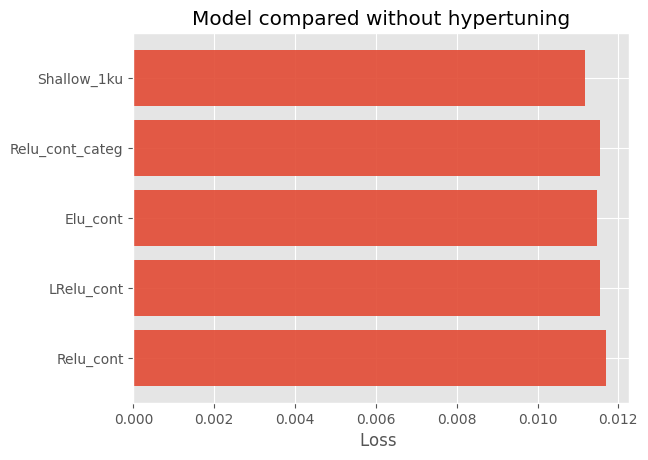

In [ ]:
import matplotlib.pyplot as plt; plt.rcdefaults()

plt.style.use('ggplot')
objects = list_model
y_pos = np.arange(len(objects))
performance = list_score
 
plt.barh(y_pos, performance, align='center', alpha=0.9)
plt.yticks(y_pos, objects)
plt.xlabel('Loss ')
plt.title('Model compared without hypertuning')
 
plt.show()

Henceforth, by the diagram above, i can conclude that Shallow Neural Network has the best score with (Final Loss on the testing set: 0.011171 and 1.70481 score on Zindi Leaderboard respectively.